# Welcome to Caustic!

In need of a differentiable strong gravitational lensing simulation package? Look no further! We have all your lensing simulator needs. In this tutorial we will cover the basics of caustic and how to get going making your own lensing configurations. Caustic is easy to use and very powerful, you will get to see some of that power here, but there will be more notebooks which demo specific use cases.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

import caustic

In [2]:
# Specify the image/cosmology parameters
n_pix = 100
res = 0.05
upsample_factor = 2
fov = res * n_pix
thx, thy = caustic.get_meshgrid(res/upsample_factor, upsample_factor*n_pix, upsample_factor*n_pix, dtype=torch.float32)
z_l = torch.tensor(0.5, dtype=torch.float32)
z_s = torch.tensor(1.5, dtype=torch.float32)
cosmology = caustic.FlatLambdaCDM(name = "cosmo")
cosmology.to(dtype=torch.float32)

FlatLambdaCDM(
    name='cosmo',
    static=[h0, critical_density_0, Om0],
    dynamic=[],
    x keys=[]
)

## Simulating an SIE lens

Here we will demo the very basics of lensing with a classic `SIE` lens model. We will see what it takes to make an `SIE` model, lens a backgorund `Sersic` source, and sample some examples in a simulator. Caustic simulators can generalize to very complex scenarios. In these cases there can be a lot of parameters moving through the simulator, and the order/number of parameters may change depending on what lens or source is being used. To streamline this process, caustic impliments a class called `Parametrized` which has some knowledge of the parameters moving through it, this way it can keep track of everything for you. For this to work, you must put the parameters into a `Packed` object which it can recognize, each sub function can then unpack the parameters it needs. Below we will show some examples of what this looks like.

In [3]:
# demo simulator with sersic source, SIE lens. then sample some examples. demo the model graph

class Simple_Sim(caustic.Simulator):
    def __init__(
        self,
        lens,
        src,
        z_s=None,
        name: str = "sim",
    ):
        super().__init__(name) # need this so `Parametrized` can do its magic
        
        # These are the lens and source objects to keep track of
        self.lens = lens
        self.src = src
        
        # Here we can add a parameter to the simulator, in this case it is `z_s` which we will need later
        self.add_param("z_s", z_s)

    def forward(self, params):# define the forward model
        # Here the simulator unpacks the parameter it needs
        z_s = self.unpack(params)

        # Note this is very similar to before, except the packed up `x` is all the raytrace function needs to work
        bx, by = self.lens.raytrace(thx, thy, z_s, params)
        mu_fine = self.src.brightness(bx, by, params)
        
        # We return the sampled brightness at each pixel location
        return avg_pool2d(mu_fine.squeeze()[None, None], upsample_factor)[0, 0]

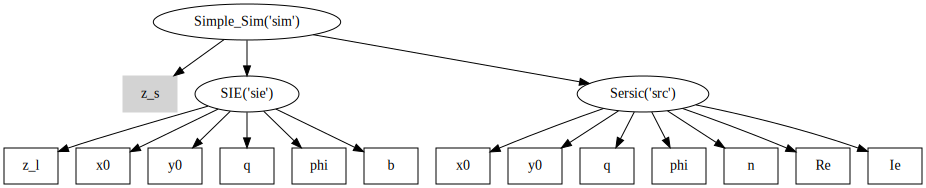

In [4]:
sie = caustic.lenses.SIE(cosmology, name = "sie")
src = caustic.sources.Sersic(name = "src")

sim = Simple_Sim(sie, src, torch.tensor(0.8))

sim.get_graph(True, True)

In [5]:
print(sim)
print(sie)

Simple_Sim(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie': ['z_l', 'x0', 'y0', 'q', 'phi', 'b']), ('src': ['x0', 'y0', 'q', 'phi', 'n', 'Re', 'Ie'])]
)
SIE(
    name='sie',
    static=[],
    dynamic=[z_l, x0, y0, q, phi, b],
    x keys=[('sie': ['z_l', 'x0', 'y0', 'q', 'phi', 'b'])]
)


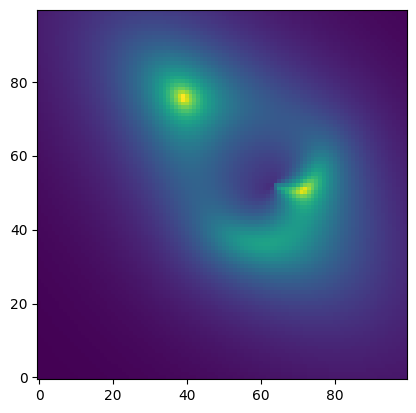

In [6]:
# Reading the x_keys above we can input the parameters that we would like the simulator to evaluate
x = torch.tensor([
    z_l.item(), # sie z_l
    0.7,     # sie x0
    0.13,    # sie y0
    0.4,     # sie q
    np.pi/5, # sie phi
    1.,      # sie b
    0.2,     # src x0
    0.5,      # src y0
    0.5,      # src q
    -np.pi/4, # src phi
    1.5,       # src n
    2.5,      # src Re
    1.,       # src Ie
])
plt.imshow(sim(x), origin="lower")
plt.show()

## Where to go next?

The caustic tutorials are generally short and to the point, that way you can idenfity what you want and jump right to some useful code that demo's the particular problem you face. Below is a list of caustic tutorials and a quick description of what you will learn in each one::

- `LensZoo`: here you can see all the built-in lens mass distributions in `caustic` and how they distort the same background Seric source.
- `Playground`: here we demo the main visualizations of a lensing system (deflection angles, convergence, potential, time delay, magnification) in an interactive display so you can change the parameters by hand and see how the visuals change!
- `VisualizeCaustics`: here you can see how to find and display caustics, a must when using `caustic`!
- `Simulators`: here we describe the powerful simulator framework and how it can be used to quickly swap models, parameters, and other features and turn a complex forward model into a simple function.
- `InvertLensEquation`: here we demo forward ray tracing in `caustic` the process of mapping from the source plane to the image plane.